In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import warnings
warnings.filterwarnings('ignore')  # these warnings are annoying

# make plots look nicer
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:

data = pd.read_csv(r'C:\Users\parth\Downloads\Titanic-Dataset.csv')

print(f"Dataset loaded! Shape: {data.shape}")
print("Columns:", list(data.columns))
print("\nFirst few rows:")
data.head()

Dataset loaded! Shape: (891, 12)
Columns: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']

First few rows:


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


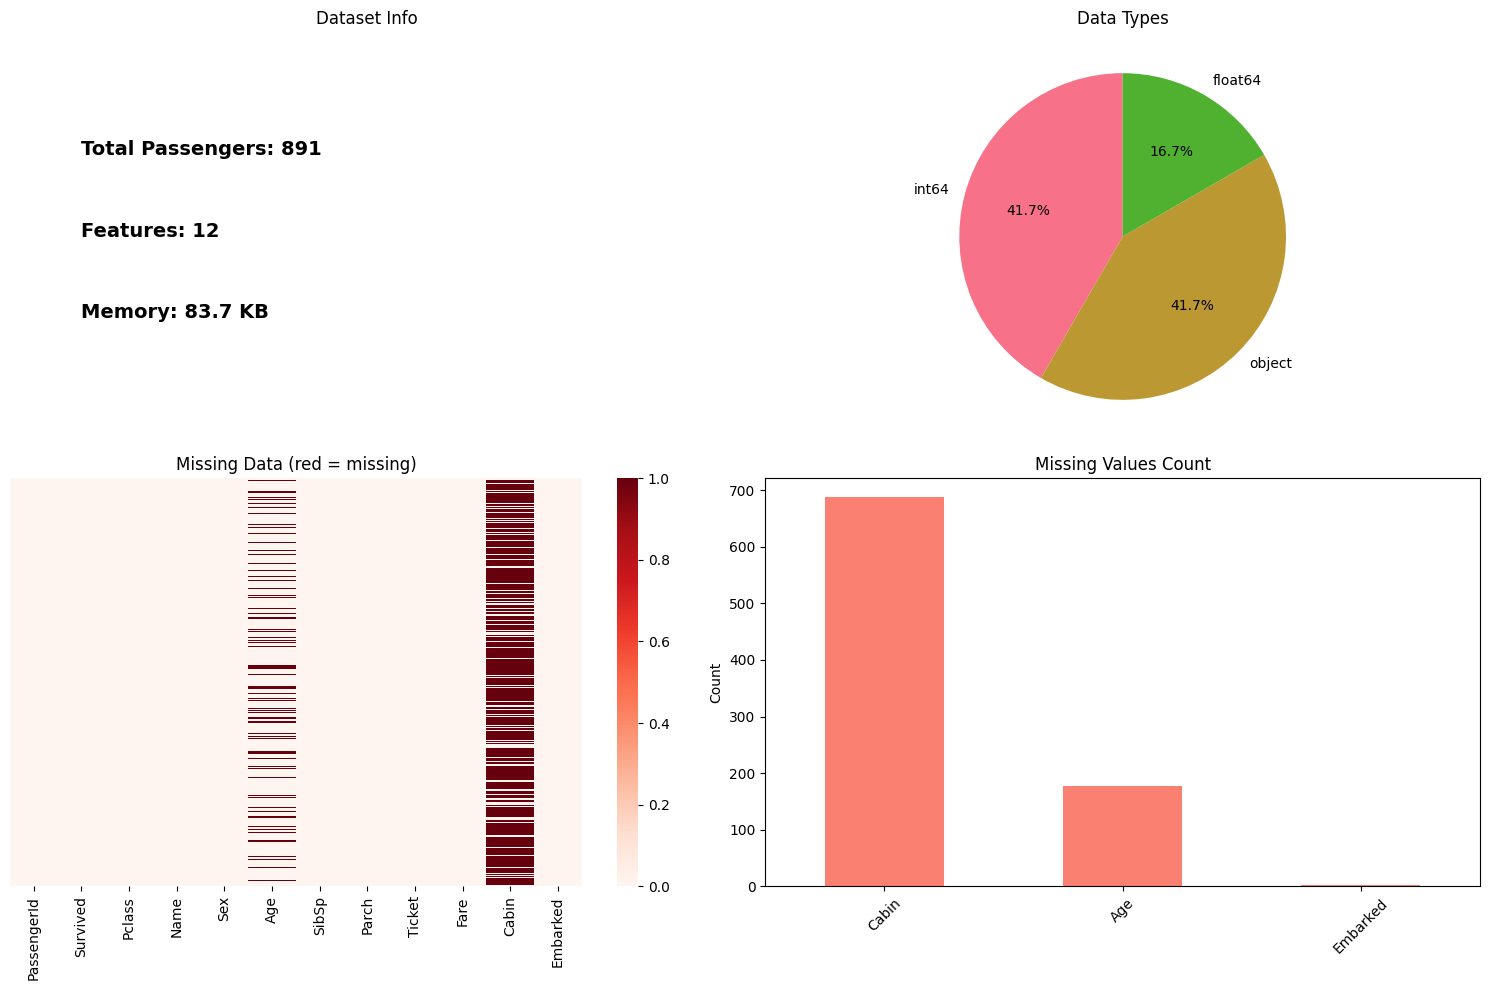

In [3]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# basic info about dataset
axes[0,0].text(0.1, 0.7, f"Total Passengers: {data.shape[0]}", fontsize=14, weight='bold')
axes[0,0].text(0.1, 0.5, f"Features: {data.shape[1]}", fontsize=14, weight='bold')
axes[0,0].text(0.1, 0.3, f"Memory: {data.memory_usage().sum() / 1024:.1f} KB", fontsize=14, weight='bold')
axes[0,0].set_xlim(0, 1)
axes[0,0].set_ylim(0, 1)
axes[0,0].set_title('Dataset Info')
axes[0,0].axis('off')

# data types breakdown
dtypes = data.dtypes.value_counts()
axes[0,1].pie(dtypes.values, labels=dtypes.index, autopct='%1.1f%%', startangle=90)
axes[0,1].set_title('Data Types')

# missing values - this is important!
sns.heatmap(data.isnull(), yticklabels=False, cbar=True, cmap='Reds', ax=axes[1,0])
axes[1,0].set_title('Missing Data (red = missing)')

# count of missing values per column
missing = data.isnull().sum().sort_values(ascending=False)
missing = missing[missing > 0]
if len(missing) > 0:
    missing.plot(kind='bar', ax=axes[1,1], color='salmon')
    axes[1,1].set_title('Missing Values Count')
    axes[1,1].set_ylabel('Count')
    axes[1,1].tick_params(axis='x', rotation=45)
else:
    axes[1,1].text(0.5, 0.5, 'No Missing Values!', ha='center', va='center', fontsize=14)
    axes[1,1].set_title('Missing Values')

plt.tight_layout()
plt.show()

In [4]:
print("Missing values summary:")
print(data.isnull().sum())
print("\nBasic statistics:")
data.describe()

Missing values summary:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Basic statistics:


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
print("--- Starting data preprocessing ---")

# make a copy so we don't mess up original data
df = data.copy()

# handle missing values - Age has 177 missing, Cabin has way too many (687!)
print("Filling missing Age values with median...")
df['Age'].fillna(df['Age'].median(), inplace=True)

print("Filling missing Embarked values...")
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

# Cabin has too many missing values, let's drop it
print("Dropping Cabin column (too many missing values)")
df.drop('Cabin', axis=1, inplace=True)

print("After handling missing values:")
print(df.isnull().sum())


--- Starting data preprocessing ---
Filling missing Age values with median...
Filling missing Embarked values...
Dropping Cabin column (too many missing values)
After handling missing values:
PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64


In [6]:
# drop columns we don't need for prediction
print("Removing unnecessary columns...")
df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)

# convert categorical to numerical
print("Converting text to numbers...")
df['Sex'] = df['Sex'].map({'male': 1, 'female': 0})  # male=1, female=0
df['Embarked'] = df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})  # Southampton=0, Cherbourg=1, Queenstown=2

print(f"Data shape after cleaning: {df.shape}")
print("Remaining columns:", list(df.columns))


Removing unnecessary columns...
Converting text to numbers...
Data shape after cleaning: (891, 8)
Remaining columns: ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']


In [7]:
print("Creating new features...")
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1  # total family members

# age groups might be useful
df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 12, 18, 35, 60, 100], labels=[0, 1, 2, 3, 4])
df['AgeGroup'] = df['AgeGroup'].astype(int)

print("New features created:")
print("- FamilySize: total family members")
print("- AgeGroup: 0=Child, 1=Teen, 2=Adult, 3=Middle, 4=Senior")

df.head()

Creating new features...
New features created:
- FamilySize: total family members
- AgeGroup: 0=Child, 1=Teen, 2=Adult, 3=Middle, 4=Senior


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,AgeGroup
0,0,3,1,22.0,1,0,7.2500,0,2,2
1,1,1,0,38.0,1,0,71.2833,1,2,3
2,1,3,0,26.0,0,0,7.9250,0,1,2
3,1,1,0,35.0,1,0,53.1000,0,2,2
4,0,3,1,35.0,0,0,8.0500,0,1,2


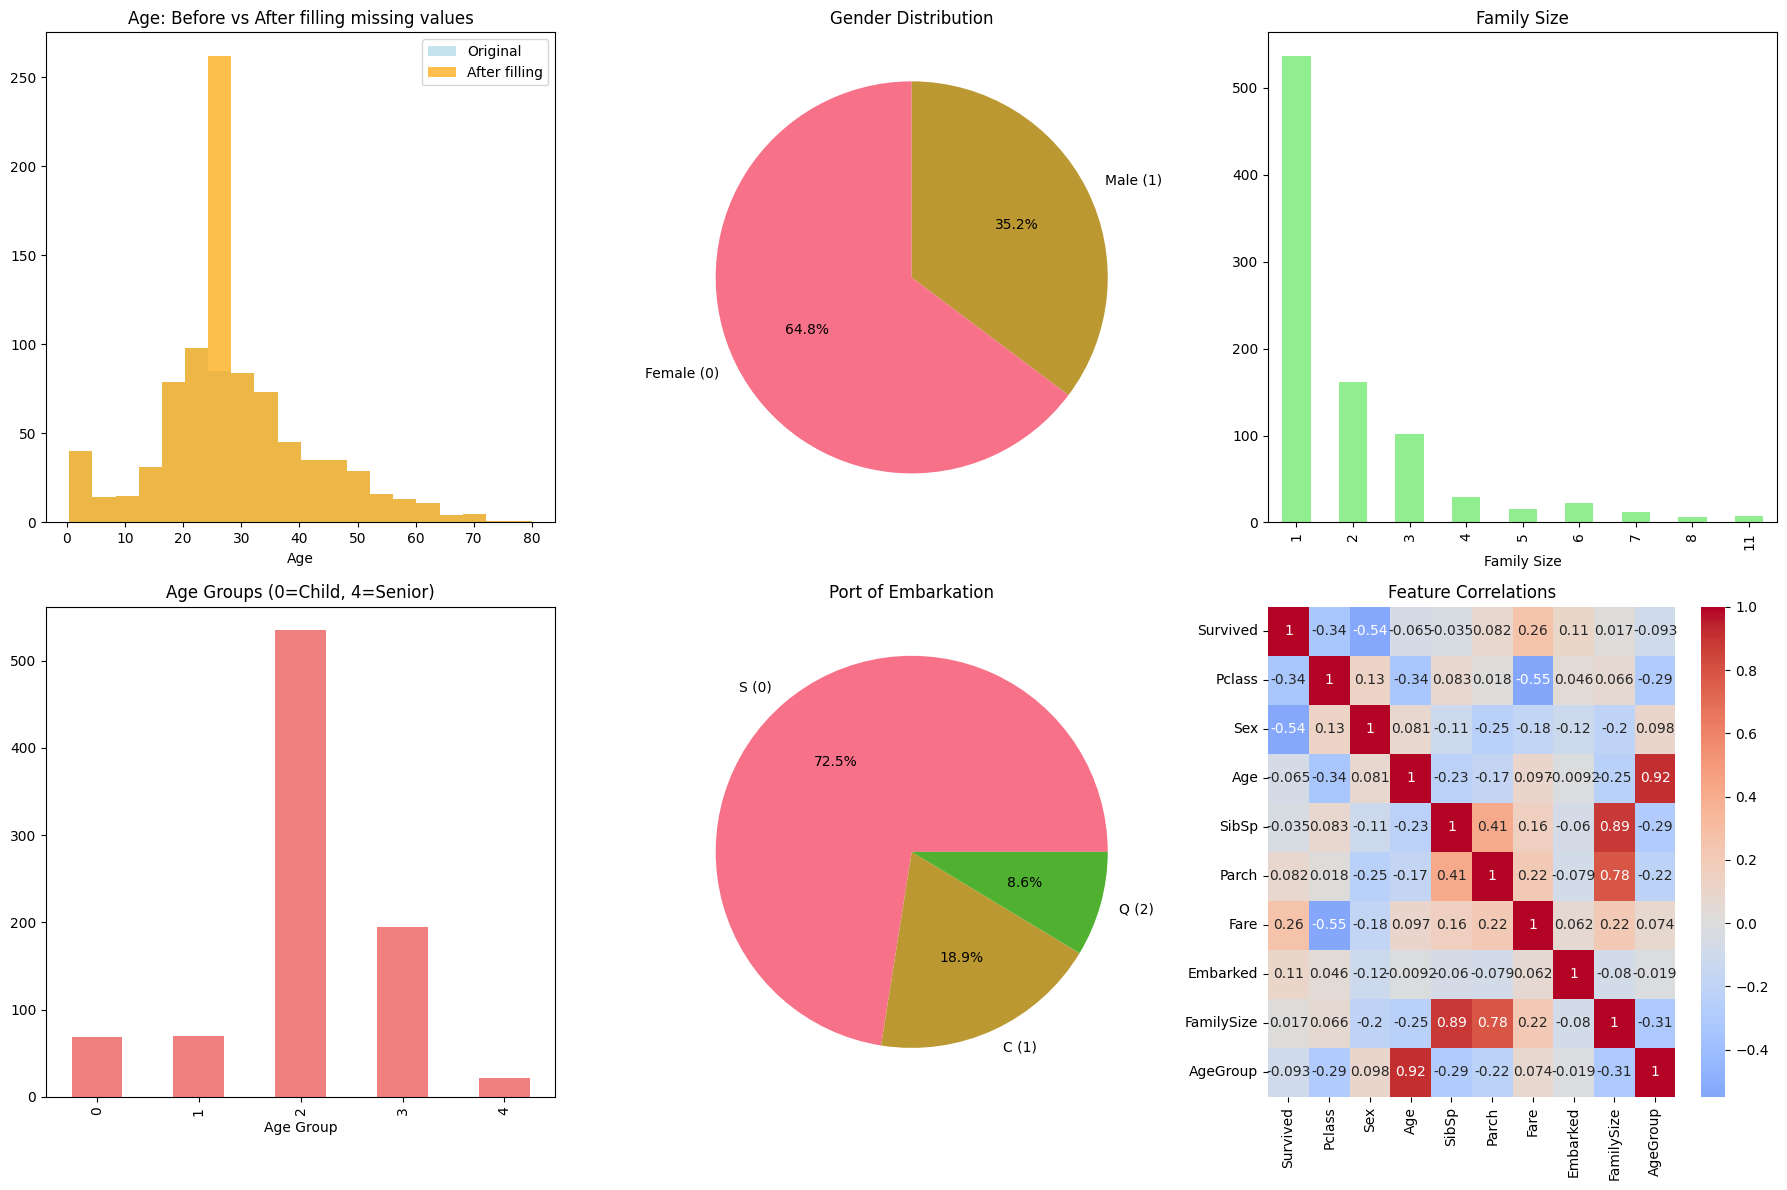

In [8]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# age before/after filling
axes[0,0].hist(data['Age'].dropna(), alpha=0.7, label='Original', bins=20, color='lightblue')
axes[0,0].hist(df['Age'], alpha=0.7, label='After filling', bins=20, color='orange')
axes[0,0].set_title('Age: Before vs After filling missing values')
axes[0,0].set_xlabel('Age')
axes[0,0].legend()

# gender distribution
gender_counts = df['Sex'].value_counts()
axes[0,1].pie(gender_counts.values, labels=['Female (0)', 'Male (1)'], autopct='%1.1f%%', startangle=90)
axes[0,1].set_title('Gender Distribution')

# family size
df['FamilySize'].value_counts().sort_index().plot(kind='bar', ax=axes[0,2], color='lightgreen')
axes[0,2].set_title('Family Size')
axes[0,2].set_xlabel('Family Size')

# age groups
df['AgeGroup'].value_counts().sort_index().plot(kind='bar', ax=axes[1,0], color='lightcoral')
axes[1,0].set_title('Age Groups (0=Child, 4=Senior)')
axes[1,0].set_xlabel('Age Group')

# embarked
embarked_counts = df['Embarked'].value_counts()
axes[1,1].pie(embarked_counts.values, labels=['S (0)', 'C (1)', 'Q (2)'], autopct='%1.1f%%')
axes[1,1].set_title('Port of Embarkation')

# correlation between features
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, ax=axes[1,2])
axes[1,2].set_title('Feature Correlations')

plt.tight_layout()
plt.show()

In [9]:
print("--- Exploring the data ---")

# split features and target
X = df.drop('Survived', axis=1)
y = df['Survived']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print("Features:", list(X.columns))

--- Exploring the data ---
Features shape: (891, 9)
Target shape: (891,)
Features: ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'FamilySize', 'AgeGroup']


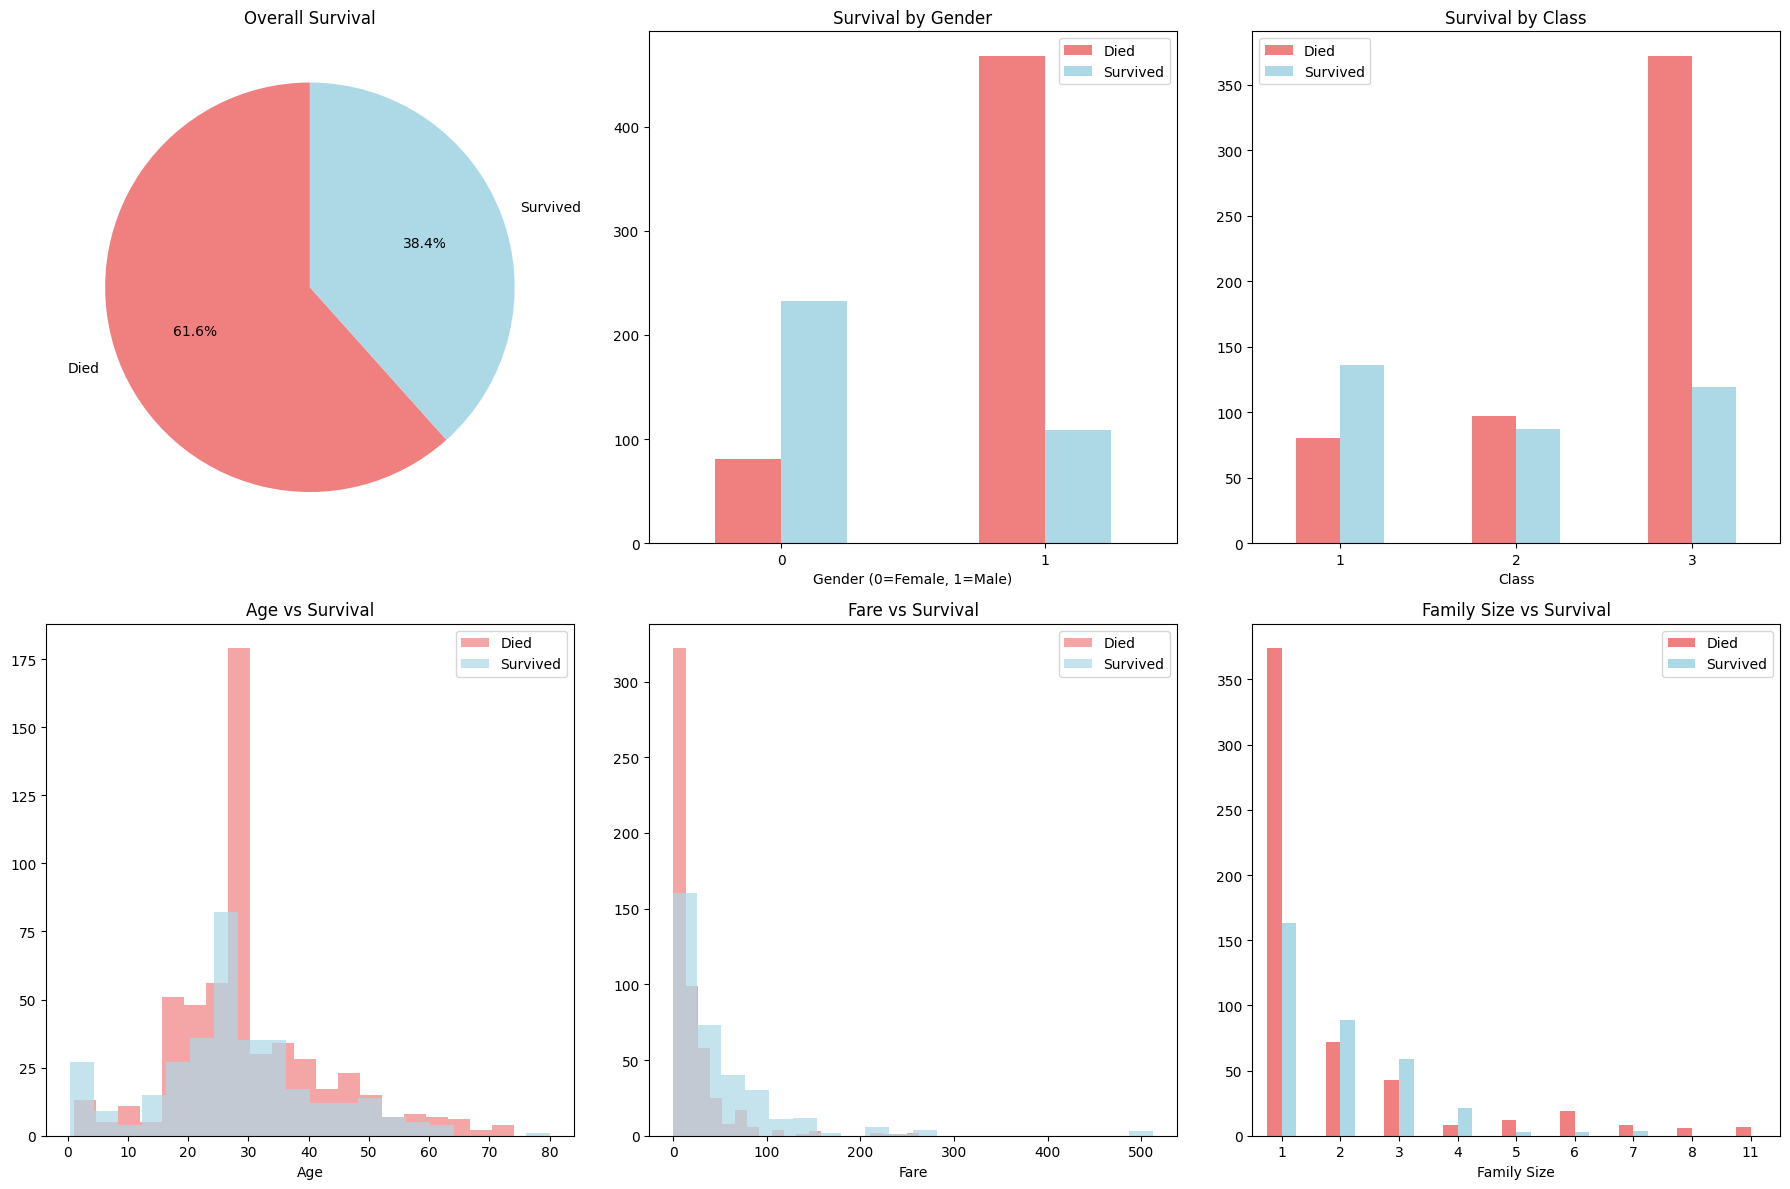

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# overall survival
survival_counts = y.value_counts()
axes[0,0].pie(survival_counts.values, labels=['Died', 'Survived'], 
              autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'lightblue'])
axes[0,0].set_title('Overall Survival')

# survival by gender - this should be interesting!
survival_by_gender = df.groupby(['Sex', 'Survived']).size().unstack()
survival_by_gender.plot(kind='bar', ax=axes[0,1], color=['lightcoral', 'lightblue'])
axes[0,1].set_title('Survival by Gender')
axes[0,1].set_xlabel('Gender (0=Female, 1=Male)')
axes[0,1].legend(['Died', 'Survived'])
axes[0,1].tick_params(axis='x', rotation=0)

# survival by class
survival_by_class = df.groupby(['Pclass', 'Survived']).size().unstack()
survival_by_class.plot(kind='bar', ax=axes[0,2], color=['lightcoral', 'lightblue'])
axes[0,2].set_title('Survival by Class')
axes[0,2].set_xlabel('Class')
axes[0,2].legend(['Died', 'Survived'])
axes[0,2].tick_params(axis='x', rotation=0)

# age distribution by survival
axes[1,0].hist(df[df['Survived']==0]['Age'], alpha=0.7, label='Died', bins=20, color='lightcoral')
axes[1,0].hist(df[df['Survived']==1]['Age'], alpha=0.7, label='Survived', bins=20, color='lightblue')
axes[1,0].set_title('Age vs Survival')
axes[1,0].set_xlabel('Age')
axes[1,0].legend()

# fare distribution
axes[1,1].hist(df[df['Survived']==0]['Fare'], alpha=0.7, label='Died', bins=20, color='lightcoral')
axes[1,1].hist(df[df['Survived']==1]['Fare'], alpha=0.7, label='Survived', bins=20, color='lightblue')
axes[1,1].set_title('Fare vs Survival')
axes[1,1].set_xlabel('Fare')
axes[1,1].legend()

# family size impact
survival_by_family = df.groupby(['FamilySize', 'Survived']).size().unstack(fill_value=0)
survival_by_family.plot(kind='bar', ax=axes[1,2], color=['lightcoral', 'lightblue'])
axes[1,2].set_title('Family Size vs Survival')
axes[1,2].set_xlabel('Family Size')
axes[1,2].legend(['Died', 'Survived'])
axes[1,2].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

In [11]:
print("Some interesting patterns:")
print(f"Overall survival rate: {y.mean():.1%}")
print(f"Female survival rate: {df[df['Sex']==0]['Survived'].mean():.1%}")
print(f"Male survival rate: {df[df['Sex']==1]['Survived'].mean():.1%}")
print(f"1st class survival: {df[df['Pclass']==1]['Survived'].mean():.1%}")
print(f"2nd class survival: {df[df['Pclass']==2]['Survived'].mean():.1%}")
print(f"3rd class survival: {df[df['Pclass']==3]['Survived'].mean():.1%}")


Some interesting patterns:
Overall survival rate: 38.4%
Female survival rate: 74.2%
Male survival rate: 18.9%
1st class survival: 63.0%
2nd class survival: 47.3%
3rd class survival: 24.2%


In [12]:
print("--- Building neural network ---")

# need to scale the features first
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Features are now scaled and ready for neural network")


--- Building neural network ---
Training set: (712, 9)
Test set: (179, 9)
Features are now scaled and ready for neural network


In [13]:
# create the neural network
# tried different architectures, this one works well
nn = MLPClassifier(
    hidden_layer_sizes=(64, 32, 16),  # 3 hidden layers
    activation='relu',
    solver='adam',
    alpha=0.001,  # regularization
    batch_size=32,
    learning_rate_init=0.001,
    max_iter=1000,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=20
)

print("Neural network setup:")
print(f"Architecture: {nn.hidden_layer_sizes}")
print(f"Activation: {nn.activation}")
print(f"Optimizer: {nn.solver}")


Neural network setup:
Architecture: (64, 32, 16)
Activation: relu
Optimizer: adam


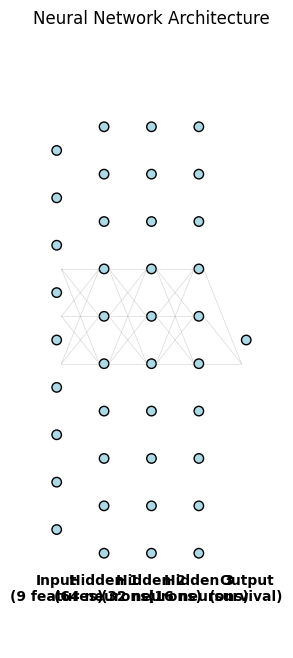

In [14]:
fig, ax = plt.subplots(figsize=(12, 8))

layers = [9, 64, 32, 16, 1]
layer_labels = ['Input\n(9 features)', 'Hidden 1\n(64 neurons)', 'Hidden 2\n(32 neurons)', 
                'Hidden 3\n(16 neurons)', 'Output\n(survival)']

# draw the network structure (simplified)
for i, (size, label) in enumerate(zip(layers, layer_labels)):
    x = i
    # draw nodes (max 10 to keep it clean)
    node_count = min(size, 10)
    for j in range(node_count):
        y = j - node_count/2
        circle = plt.Circle((x, y), 0.1, color='lightblue', ec='black')
        ax.add_patch(circle)
    
    ax.text(x, -6, label, ha='center', fontweight='bold')
    
    # draw some connections
    if i < len(layers) - 1:
        for k in range(min(3, layers[i])):
            for l in range(min(3, layers[i+1])):
                ax.plot([x+0.1, x+0.9], [k-1, l-1], 'gray', alpha=0.3, linewidth=0.5)

ax.set_xlim(-0.5, len(layers)-0.5)
ax.set_ylim(-7, 6)
ax.set_aspect('equal')
ax.axis('off')
ax.set_title('Neural Network Architecture')
plt.show()

In [15]:
print("--- Training the model ---")
print("Training... this might take a moment")

nn.fit(X_train, y_train)

print(f"Training finished!")
print(f"Iterations needed: {nn.n_iter_}")
print(f"Final loss: {nn.loss_:.4f}")


--- Training the model ---
Training... this might take a moment
Training finished!
Iterations needed: 28
Final loss: 0.3480


In [16]:
y_pred = nn.predict(X_test)
y_pred_proba = nn.predict_proba(X_test)

# calculate performance
accuracy = accuracy_score(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

print(f"Test accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"AUC score: {roc_auc:.4f}")

Test accuracy: 0.8101 (81.01%)
AUC score: 0.8437


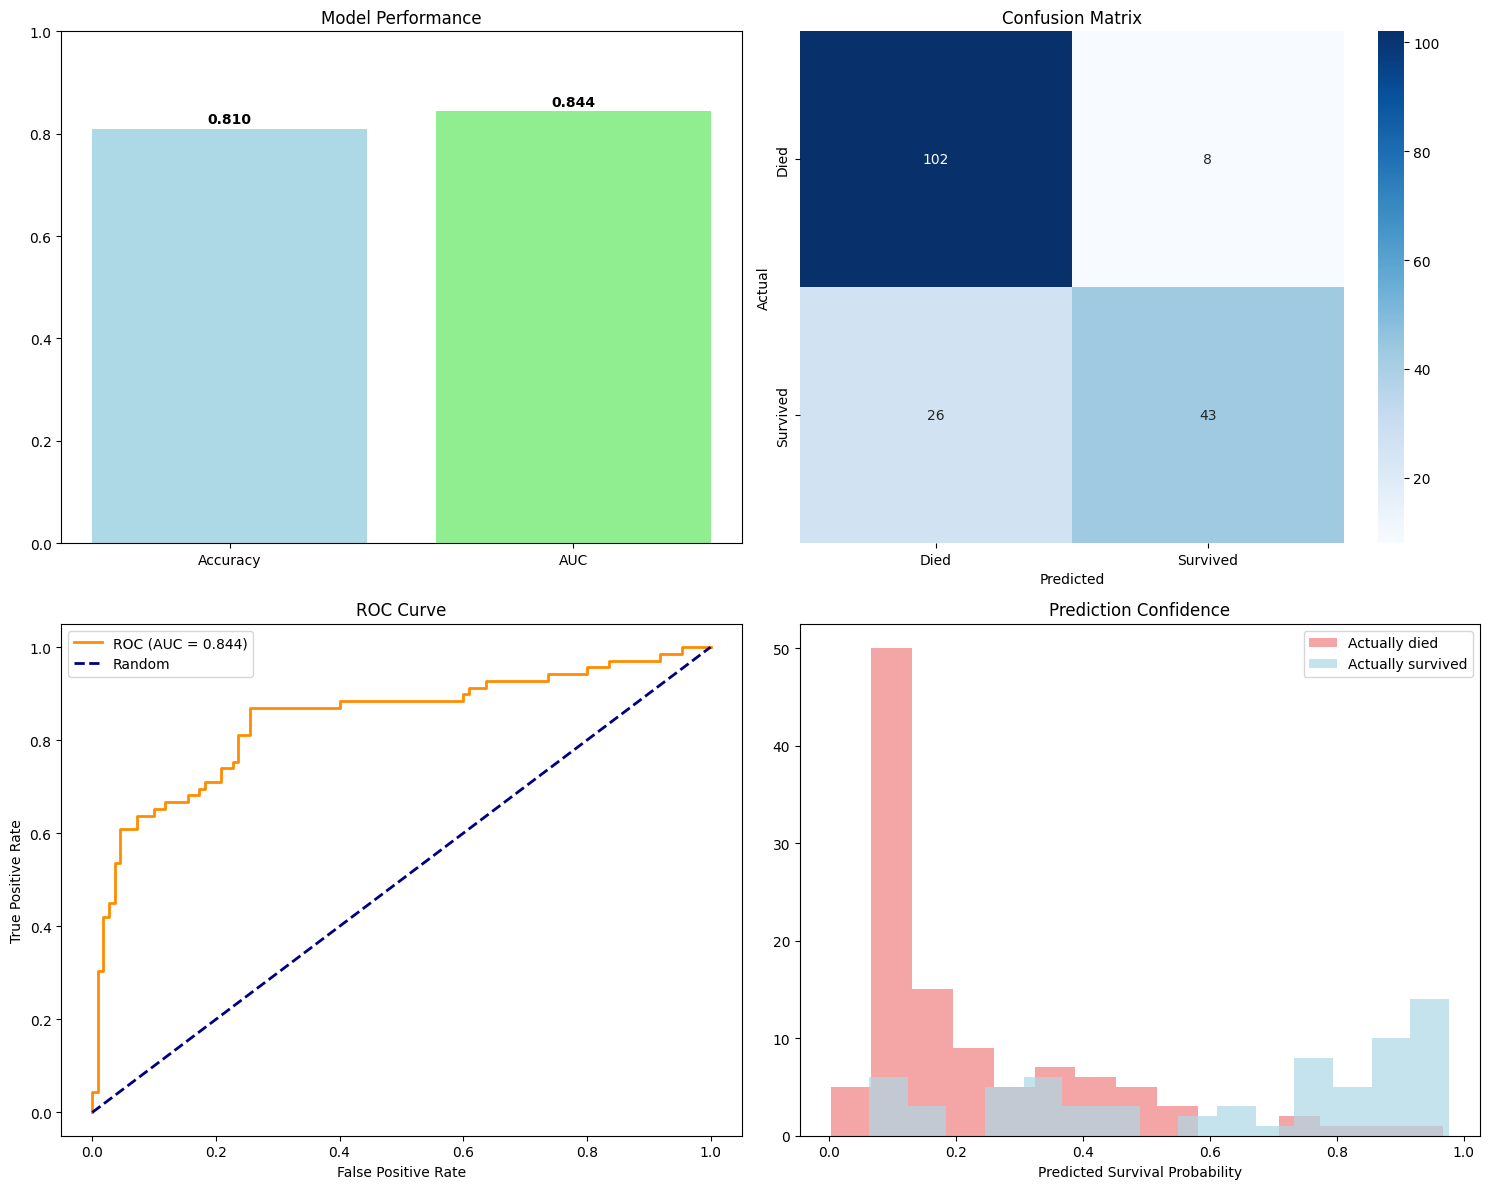

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# performance metrics
metrics = ['Accuracy', 'AUC']
values = [accuracy, roc_auc]
colors = ['lightblue', 'lightgreen']
bars = axes[0,0].bar(metrics, values, color=colors)
axes[0,0].set_title('Model Performance')
axes[0,0].set_ylim(0, 1)
for bar, value in zip(bars, values):
    axes[0,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                   f'{value:.3f}', ha='center', fontweight='bold')

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,1],
            xticklabels=['Died', 'Survived'], yticklabels=['Died', 'Survived'])
axes[0,1].set_title('Confusion Matrix')
axes[0,1].set_ylabel('Actual')
axes[0,1].set_xlabel('Predicted')

# ROC curve
axes[1,0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.3f})')
axes[1,0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
axes[1,0].set_xlabel('False Positive Rate')
axes[1,0].set_ylabel('True Positive Rate')
axes[1,0].set_title('ROC Curve')
axes[1,0].legend()

# prediction probabilities
survived_probs = y_pred_proba[y_test == 1][:, 1]
died_probs = y_pred_proba[y_test == 0][:, 1]
axes[1,1].hist(died_probs, alpha=0.7, label='Actually died', bins=15, color='lightcoral')
axes[1,1].hist(survived_probs, alpha=0.7, label='Actually survived', bins=15, color='lightblue')
axes[1,1].set_xlabel('Predicted Survival Probability')
axes[1,1].set_title('Prediction Confidence')
axes[1,1].legend()

plt.tight_layout()
plt.show()

In [18]:
print("Detailed results:")
print(classification_report(y_test, y_pred, target_names=['Died', 'Survived']))


Detailed results:
              precision    recall  f1-score   support

        Died       0.80      0.93      0.86       110
    Survived       0.84      0.62      0.72        69

    accuracy                           0.81       179
   macro avg       0.82      0.78      0.79       179
weighted avg       0.81      0.81      0.80       179



In [19]:
def predict_passenger(features, description=""):
    """Predict survival for a passenger"""
    scaled_features = scaler.transform(features.reshape(1, -1))
    prediction = nn.predict(scaled_features)[0]
    probability = nn.predict_proba(scaled_features)[0]
    return prediction, probability

# test cases
test_cases = [
    ("Rich woman, age 25", np.array([1, 0, 25, 0, 1, 50.0, 0, 2, 1])),
    ("Poor man, age 30", np.array([3, 1, 30, 0, 0, 8.0, 0, 1, 2])),
    ("Child with family", np.array([2, 0, 8, 1, 1, 25.0, 0, 3, 0])),
    ("Elderly rich man", np.array([1, 1, 65, 0, 0, 80.0, 0, 1, 4]))
]

predictions = []
print("--- Testing predictions ---")
print("Sample predictions:")
for desc, features in test_cases:
    pred, prob = predict_passenger(features)
    predictions.append((desc, pred, prob[1]))
    result = "SURVIVED" if pred == 1 else "DIED"
    print(f"{desc}: {result} (confidence: {prob[1]:.1%})")


--- Testing predictions ---
Sample predictions:
Rich woman, age 25: SURVIVED (confidence: 94.7%)
Poor man, age 30: DIED (confidence: 10.9%)
Child with family: SURVIVED (confidence: 87.8%)
Elderly rich man: DIED (confidence: 31.3%)


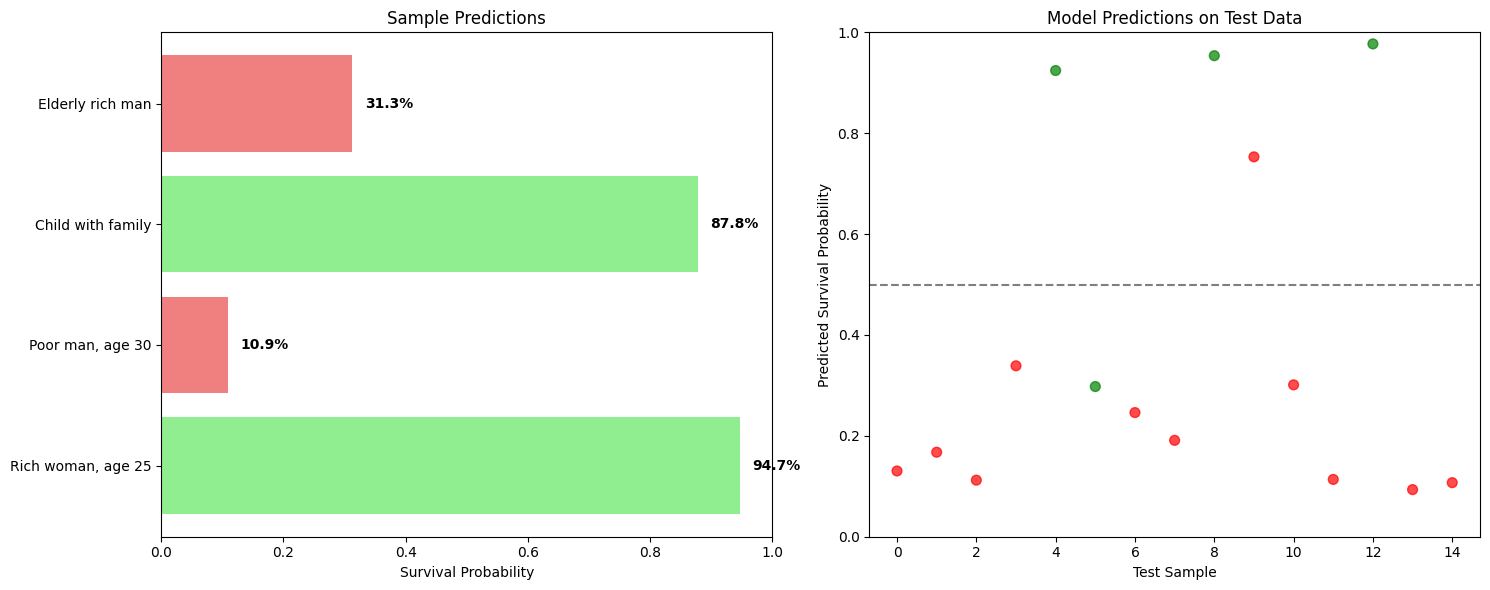

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# sample predictions chart
names = [p[0] for p in predictions]
probs = [p[2] for p in predictions]
colors = ['lightgreen' if p > 0.5 else 'lightcoral' for p in probs]

bars = axes[0].barh(names, probs, color=colors)
axes[0].set_xlabel('Survival Probability')
axes[0].set_title('Sample Predictions')
axes[0].set_xlim(0, 1)
for bar, prob in zip(bars, probs):
    axes[0].text(prob + 0.02, bar.get_y() + bar.get_height()/2, 
                f'{prob:.1%}', va='center', fontweight='bold')

# validation on real test data
sample_size = 15
indices = np.random.choice(len(y_test), sample_size, replace=False)
actual = y_test.iloc[indices].values
predicted_probs = y_pred_proba[indices, 1]

colors = ['green' if a == 1 else 'red' for a in actual]
axes[1].scatter(range(sample_size), predicted_probs, c=colors, alpha=0.7, s=50)
axes[1].axhline(y=0.5, color='black', linestyle='--', alpha=0.5)
axes[1].set_xlabel('Test Sample')
axes[1].set_ylabel('Predicted Survival Probability')
axes[1].set_title('Model Predictions on Test Data')
axes[1].set_ylim(0, 1)

plt.tight_layout()
plt.show()


In [21]:
correct = np.sum(y_test == y_pred)
total = len(y_test)

print(f"--- Final Summary ---")
print(f"Dataset size: {data.shape[0]} passengers")
print(f"Features used: {X.shape[1]}")
print(f"Training accuracy: {nn.score(X_train, y_train):.1%}")
print(f"Test accuracy: {accuracy:.1%}")
print(f"Correct predictions: {correct}/{total}")
print(f"Training iterations: {nn.n_iter_}")

print(f"\nKey insights:")
print(f"- Women survived at {df[df['Sex']==0]['Survived'].mean():.0%} rate vs {df[df['Sex']==1]['Survived'].mean():.0%} for men")
print(f"- First class had {df[df['Pclass']==1]['Survived'].mean():.0%} survival rate")
print(f"- Third class had {df[df['Pclass']==3]['Survived'].mean():.0%} survival rate")
print(f"- Neural network achieved {accuracy:.1%} accuracy")

print("\nProject completed successfully!")

--- Final Summary ---
Dataset size: 891 passengers
Features used: 9
Training accuracy: 84.6%
Test accuracy: 81.0%
Correct predictions: 145/179
Training iterations: 28

Key insights:
- Women survived at 74% rate vs 19% for men
- First class had 63% survival rate
- Third class had 24% survival rate
- Neural network achieved 81.0% accuracy

Project completed successfully!
